# <p style="text-align: center;"> CS6476 | Computer Vision ps3 </p>
<p style="text-align: center;">Alexis Durocher - MSCS student at Georgia Tech</p>
<p style="text-align: center;">Spring 2018</p>


In [1]:
import cv2

from scipy import ndimage
from scipy import misc
import numpy as np
import math as mtugh
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from  scipy.optimize import minimize

<i> In this project we will epxlore calibrating a camera with respect to 3D world coordinates as well as estimating the relationship between two camera views. </i>

<u> Note of use </u>

Note that, in order to facilitate the parsing of coordinates data. We have convert our .txt file in .csv file with an appropriate format and comat separator.

### 1. Calibration

<i> Our goal is to compute the projection matrix that goes from world 3D coordinates to 2D image coordinate. Note that we could solve the 3x4 matrix M using either SVD to solve the homogeneous version of the equations or by setting m3,4 to 1 and then using the normal least squares method. M is only known up to a scale factor.</i>

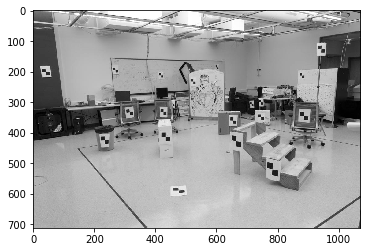

In [2]:
image_a = cv2.imread("./pic_a.jpg", 0)
plt.imshow(image_a, cmap = 'gray')
plt.show()

In [3]:
data_2D_norm = pd.read_csv('./pts2d-norm-pic_a.csv')
data_3D_norm = pd.read_csv('./pts3d-norm.csv')
df_data_norm = pd.concat([data_3D_norm, data_2D_norm], axis = 1)
df_data_norm = pd.DataFrame(df_data_norm, columns=['x','y','z','u','v'])
m = np.array([])
df_data_norm.head(n=5)

x       y       z       u       v
0  1.5706 -0.1490  0.2598  1.0486 -0.3645
1 -1.5282  0.9695  0.3802 -1.6851 -0.4004
2 -0.6821  1.2856  0.4078 -0.9437 -0.4200
3  0.4124 -1.0201 -0.0915  1.0682  0.0699
4  1.2095  0.2812 -0.1280  0.6077 -0.0771

#### 1.1) How to compute M

##### a. Find M, the projection matrix

We try here, both techniques.
First, we compute M by minimizing the squared Norm(AM). With constraint on Norm(M) = 1 and random M initialization.
Second, we use a SVD to find out the eigen vectors and since we are trying to minimize, keep only the last row (last corresponding eigen vector).


In [4]:
def build_A(df_data):
    A = np.array([0,0,0,0,0,0,0,0,0,0,0,0])
    for index, pt in df_data.iterrows():
        row_u = np.append([pt['x'], pt['y'], pt['z'], 1, 0, 0, 0, 0,
                        -pt['u']*pt['x'], -pt['u']*pt['y'], -pt['u']*pt['z']], -pt['u'])
        row_v = np.append([0, 0, 0, 0, pt['x'], pt['y'], pt['z'], 1,
                           -pt['v']*pt['x'], -pt['v']*pt['y'], -pt['v']*pt['z']], -pt['v'])
        A = np.vstack((A, row_u, row_v))
        A.dtype = np.dtype('f8')
    #remove first row
    return A[1:]

In [5]:
A = build_A(df_data_norm)
m0 = np.random.random(12)

In [6]:
def compute_M(A, m0):
    # constraint on norm m = 1
    cstr = ({'type': 'eq', 'fun': lambda m:  np.linalg.norm(m) - 1 })
    
    def compute_sse_for_M(m):
        return np.linalg.norm(np.dot(A,m))**2

    M = minimize(compute_sse_for_M, m0, constraints=cstr).x
    M = np.array(M, ndmin=2)
    M.shape = (3,4)
    return - M

def compute_M_SVD(A):
    u, s, vh = np.linalg.svd(A, full_matrices=False)
    M = np.array(vh[-1], ndmin=2)
    M.shape = (3,4)
    return - M

M_norm = compute_M(A, m0)
print(M_norm)

M_norm_svd = compute_M_SVD(A)
print(M_norm_svd)

[[ 0.45826943 -0.29476094 -0.01387522  0.00403239]
 [-0.0508549  -0.05456548 -0.54109714 -0.05237688]
 [ 0.10901009  0.17830963 -0.0441434   0.59680578]]
[[-0.45827554  0.29474237  0.01395746 -0.0040258 ]
 [ 0.05085589  0.0545847   0.54105993  0.05237592]
 [-0.10900958 -0.17834548  0.04426782 -0.5968205 ]]


##### b. Test M

In [7]:
def project_3D_pts(M, pt_3D):
    pt_3D = np.append(pt_3D, [1])
    return np.dot(M, pt_3D)

def convert_homog_to_nonhomog(pt):
    non_homog = pt/pt[-1]
    return np.array(non_homog[:-1])

def compute_residual(pt, pt_pred):
    #print(pt, pt_pred)
    diff = pt - pt_pred
    return np.linalg.norm(diff)

def compute_total_residual(M, data_k):
    total_res = 0
    k = len(data_k)
    #print(data_k, k)
    for index, pt in data_k.iterrows():
        pt_3D = pt.values[0:3]
        pt_2D = pt.values[3:]
        pt_2D_pred = convert_homog_to_nonhomog(project_3D_pts(M, pt_3D))
        total_res += compute_residual(pt_2D, pt_2D_pred)
    return total_res/k    

In [8]:
pt_3D = data_3D_norm.values[-1]
pt_2D = data_2D_norm.values[-1]
pt_2D_pred = convert_homog_to_nonhomog(project_3D_pts(M_norm, pt_3D))
print("Last real 2D point = ", pt_2D)
print("Last predicted 2D point = ", pt_2D_pred)
print("Residual error =", compute_residual(pt_2D, pt_2D_pred))

Last real 2D point =  [ 0.1406 -0.4527]
Last predicted 2D point =  [ 0.14191714 -0.45183597]
Residual error = 0.0015752502151


#### 1.2) Find optimal M

To find out the optimal M, based on the residual error metric, we will first test different size of set of sample/training data, then compute the M Matrix and finally it's corresponding residual error. We will try sets of k = 8, 12 and 16 training points, 10 times each to have an average estimation of the residual error.

Now, we use different datasets of 2D and 3D points, than the normalized ones used above

In [9]:
data_2D_b = pd.read_csv('./pts2d-pic_b.csv')
data_3D = pd.read_csv('./pts3d.csv')
df_data_2 = pd.concat([data_3D, data_2D_b], axis = 1)
df_data_2 = pd.DataFrame(df_data_2, columns=['x','y','z','u','v'])
df_data_2.head(n=5)

x        y       z    u    v
0  312.747  309.140  30.086  731  238
1  305.796  311.649  30.356   22  248
2  307.694  312.358  30.418  204  230
3  310.149  307.186  29.298  903  342
4  311.937  310.105  29.216  635  316

In [52]:
import random
epoch = 10

def test_M_for_k(k, df_data):
    idx = list(df_data.index.values)
    
    # random k train idx
    train_idx_k = random.sample(idx, k)
    train_data_k = df_data.ix[train_idx_k]
    # random 4 test idx
    test_idx = [x for x in idx if x not in train_idx_k]
    test_idx_4 = random.sample(test_idx, 4)
    test_data_k = df_data.ix[test_idx_4]
    
    # train M
    A = build_A(train_data_k)
    M = compute_M_SVD(A)
    # test M
    res = 0
    res = compute_total_residual(M, test_data_k)
    return M, res

# for k = 8
res_8 = 0
k = 8
for i in range(0, epoch):
    M8, res_i8 = test_M_for_k(k, df_data_2)
    res_8 += res_i8
res_8 = res_8 / 10
print("For k = ", k, " residual mean error = ", res_8)

# for k = 12
res_12 = 0
k = 12
for i in range(0, epoch):
    M12, res_i12 = test_M_for_k(k, df_data_2)
    res_12 += res_i12
res_12 = res_12 / 10
print("For k = ", k, " residual mean error = ", res_12)

# for k = 16
res_16 = 0
k = 16
for i in range(0, epoch):
    M16, res_i16 = test_M_for_k(k, df_data_2)
    res_16 += res_i16
res_16 = res_16 / 10
print("For k = ", k, " residual mean error = ", res_16)


For k =  8  residual mean error =  2.11197567722
For k =  12  residual mean error =  1.29390021113
For k =  16  residual mean error =  1.50582338923


<u> Interpretation </u>

First, we can notice that the residual mean error is way higher on this un-normalized dataset.

Second, as we can see, the residual average error decreases for a size of k = 12 and increases for a size of k = 16. This makes sense since adding new samples in the M solving adds more rows/equations in the sytem. Thus, this gives more information and results in more accuracy in our final M. However, a too big training sample (here k = 16) leads to overconstraining the system and results in a loss of accuracy on test data.

The final M, hence is given for a training data set of k = 12 samples.

In [53]:
M12

array([[ -7.11338172e-03,   4.23615231e-03,   9.98258486e-04,
          8.23277484e-01],
       [ -1.55834489e-03,  -1.04447091e-03,   7.39982161e-03,
          5.67515910e-01],
       [ -7.75893441e-06,  -3.78721875e-06,   1.34208091e-06,
          3.47245456e-03]])

#### 1.3) Compute C, the center of our Camera

Recall : 

M = [Q|m4]

C = ${−Q^−1}$ * m4

In [54]:
def compute_C(M):
    Q = M[:, 0:3]
    m4 = M[:, -1]
    Q_inv = np.linalg.inv(Q)
    C = np.dot(-Q_inv, m4)
    return C

In [55]:
compute_C(M12)

array([ 302.90219212,  307.11595372,   30.44449797])

We use, here the M found with a k size = 12.

### 2. Fundamental Matrix Estimation

Now, the goal is to estimate the matching between points in one picture to lines in an other picture. We will use the fundamental matrix F.


In [14]:
data_2D_a = pd.read_csv('./pts2d-pic_a.csv')
data_2D_a.columns = ['ua','va']
data_2D_b = pd.read_csv('./pts2d-pic_b.csv')
data_2D_b.columns = ['ub','vb']
df_data_3 = pd.concat([data_2D_a, data_2D_b], axis = 1)
df_data_3 = pd.DataFrame(df_data_3)
df_data_3.head(n=5)

ua   va   ub   vb
0  880  214  731  238
1   43  203   22  248
2  270  197  204  230
3  886  347  903  342
4  745  302  635  316

In [15]:
# compute their relative position in both camera system using M

#### 2.1) LSE to compute F 

In [16]:
# function to build the matrix X, such that Xf = 0. With f unknown : a flattened version of F.
def build_X(df_data):
    X = np.array([0,0,0,0,0,0,0,0,0])
    #print(X)
    for index, pt in df_data.iterrows():
        new_row = np.array([pt['ub'] * pt['ua'], pt['ub'] * pt['va'], pt['ub'],
                            pt['vb'] * pt['ua'], pt['vb'] * pt['va'], pt['vb'],
                            pt['ua'], pt['va'], 1,])
        X = np.vstack((X, new_row))
    return X[1:]

In [26]:
X = build_X(df_data_3)


In [31]:
def compute_F_SVD(X):
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    F = np.array(vh[-1], ndmin=2)
    F.shape = (3,3)
    return - F

F_SVD = compute_F_SVD(X)
print(F_SVD)

[[  6.60698417e-07  -7.91031621e-06   1.88600198e-03]
 [ -8.82396296e-06  -1.21382933e-06  -1.72332901e-02]
 [  9.07382302e-04   2.64234650e-02  -9.99500092e-01]]


#### 2.2)  Ajust rank of F 3 -> 2

In [34]:
u, s, vh = np.linalg.svd(F_SVD, full_matrices=True)
assert(np.allclose(F_SVD, np.dot(u * s, vh)))
# remove last smaller singular value
s[2] = 0
print(np.diag(s))
# reconstruc F'
F_bis = np.dot(u*s, vh)
print(F_bis)
print(F_SVD)

[[  9.99999895e-01   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   4.59155649e-04   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]]
[[  5.36264198e-07  -7.90364771e-06   1.88600204e-03]
 [ -8.83539184e-06  -1.21321685e-06  -1.72332901e-02]
 [  9.07382264e-04   2.64234650e-02  -9.99500092e-01]]
[[  6.60698417e-07  -7.91031621e-06   1.88600198e-03]
 [ -8.82396296e-06  -1.21382933e-06  -1.72332901e-02]
 [  9.07382302e-04   2.64234650e-02  -9.99500092e-01]]


#### 2.3) Compute corresponding epipolar lines

Recall that epipolar line ${l_a}$ (respectively ${l_b}$) corresponding to point ${p_b}$ (respectively ${p_a}$) can be computed with :

${l_b}$ = F${p_a}$

${l_a}$ = ${F^T}$${p_b}$ 

In [35]:
# compute epipolar lines
lb_lines = np.array([0,0,0])
la_lines = np.array([0,0,0])

for pta, ptb in zip(data_2D_a.values, data_2D_b.values):
    pta = np.append(pta, [1])
    ptb = np.append(ptb, [1])
    lb = np.dot(F_bis, pta)
    la = np.dot(F_bis, ptb)
    lb_lines = np.vstack((lb_lines, lb))
    la_lines = np.vstack((la_lines, la))

lb_lines = lb_lines[1:]
la_lines = la_lines[1:]

To draw the epilolar lines from their homogenous coordinates, we first need to find out the coordinates of the left and right line border of the picture. Indeed, this will allow us to compute the cross product with our lines and thus, find two points from which to draw lines.

With h and w the picture's height and width and X the cross-product, Recall :

${l_L}$ = ${(0, 0, 1)}$ X ${(0, h, 1)}$

${l_R}$ = ${(w, h, 1)}$ X ${(w, 0, 1)}$

In [38]:
# find lL and lR
h, w = image_a.shape
l_L = np.cross(np.array([0, 0, 1]), np.array([0, h, 1]))
l_R = np.cross(np.array([w, 0, 1]), np.array([w, h, 1]))
print(l_L, l_R)

[-712    0    0] [  -712      0 763264]


We can now, find two points on each right and left border of the picture b (same for a) by computing :
    
${pb_L}$ = ${l_L}$ X ${l_b}$

${pb_R}$ = ${l_R}$ X ${l_b}$

In [39]:
pts_al_lines = np.array([0,0])
pts_ar_lines = np.array([0,0])
pts_bl_lines = np.array([0,0])
pts_br_lines = np.array([0,0])

for lb_line, la_line in zip(lb_lines, la_lines):
    pb_l = np.array(convert_homog_to_nonhomog(np.cross(lb_line, l_L)), dtype= np.int32)
    pb_r = np.array(convert_homog_to_nonhomog(np.cross(lb_line, l_R)), dtype= np.int32)
    pa_l = np.array(convert_homog_to_nonhomog(np.cross(la_line, l_L)), dtype= np.int32)
    pa_r = np.array(convert_homog_to_nonhomog(np.cross(la_line, l_R)), dtype= np.int32)
    pts_al_lines = np.vstack((pts_al_lines, pa_l))
    pts_ar_lines = np.vstack((pts_ar_lines, pa_r))
    pts_bl_lines = np.vstack((pts_bl_lines, pb_l))
    pts_br_lines = np.vstack((pts_br_lines, pb_r))

pts_al_lines = pts_al_lines[1:]
pts_ar_lines = pts_ar_lines[1:]
pts_bl_lines = pts_bl_lines[1:]
pts_br_lines = pts_br_lines[1:]

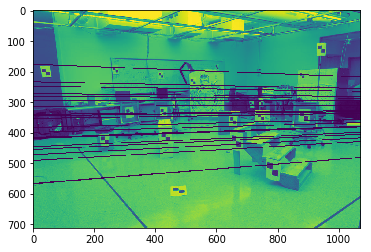

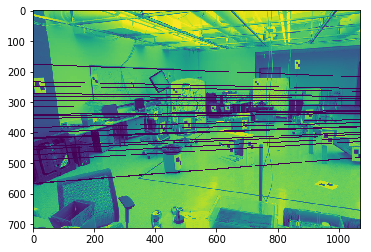

In [56]:
image_a = cv2.imread("./pic_a.jpg",0)
image_b = cv2.imread("./pic_b.jpg",0)

# draw line on picture a 
for pta_l, pta_r, ptb_l, ptb_r in zip(pts_al_lines, pts_ar_lines, pts_bl_lines, pts_br_lines):
    image_a_with_lines = cv2.line(image_a, tuple(pta_l), tuple(pta_r), (0,255,0), 2)
    image_b_with_lines = cv2.line(image_b, tuple(pta_l), tuple(pta_r), (0,255,0), 2)


plt.imshow(image_a_with_lines)
plt.imsave("./output/image_a_with_lines.png", image_a_with_lines)
plt.show()

plt.imshow(image_b_with_lines)
plt.imsave("./output/image_b_with_lines.png", image_b_with_lines)
plt.show()

### 3. Bonus